# Importing utilities

These steps are used to import the main libraries and utilites for the overall project (doesn't include custom functions)

In [7]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
import re

ImportError: DLL load failed while importing _fblas: The specified module could not be found.

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Available GPUs: ", tf.config.list_physical_devices('GPU'))

tf.debugging.set_log_device_placement(False)

Num GPUs Available:  0
Available GPUs:  []


# Importing and visualizing data

Visualizing the columns of train, test and validation data

In [ ]:
train_data = pd.read_csv("data/train.csv")
val_data = pd.read_csv("data/val.csv")
test_data = pd.read_csv("data/test.csv")

In [ ]:
train_data.head()

In [ ]:
val_data.head()

In [ ]:
test_data.head()

In [ ]:
scores = train_data['score']

plt.figure(figsize=(8, 6))
plt.hist(scores, bins=int((scores.max() - scores.min()) / 0.25), edgecolor='black', color='skyblue')
plt.title("Histogram of Train Data Scores", fontsize=16)
plt.xlabel("Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
scores = val_data['score']

plt.figure(figsize=(8, 6))
plt.hist(scores, bins=int((scores.max() - scores.min()) / 0.25), edgecolor='black', color='skyblue')
plt.title("Histogram of Validation Data Scores", fontsize=16)
plt.xlabel("Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Processing data

We first split training and validation data into features and labels.
Steps required to preprocess data -> standardization (getting to mean 0 and var 1)

In [2]:
train_texts, train_scores = train_data["text"], train_data["score"]
val_texts, val_scores = val_data["text"], val_data["score"]

NameError: name 'train_data' is not defined

In [11]:
test_texts = test_data["text"]
test_ids = test_data["id"]

In [12]:
train_scores_mean = np.mean(train_scores)
val_scores_mean = np.mean(val_scores)
train_scores_std = np.std(train_scores)
val_scores_std = np.std(val_scores)

print(train_scores_mean, val_scores_mean, train_scores_std, val_scores_std)

train_scores_standardized = (train_scores-train_scores_mean)/train_scores_std
val_scores_standardized = (val_scores-val_scores_mean)/val_scores_std

0.5207909438130168 0.4804607335511433 0.8170724587154942 0.8145994110809934


In [13]:
train_scores_standardized.head()

0   -1.453308
1   -0.637386
2    0.994456
3    1.402416
4   -0.331416
Name: score, dtype: float64

In [14]:
val_scores_standardized.head()

0   -0.896712
1    1.333423
2    0.944684
3   -1.612810
4   -0.589812
Name: score, dtype: float64

# Text vectorization

Since many words are repeating and some have a strong influence on the visual score of the sentence, it makes sense to quantify (vectorize) the text data

In [ ]:
train_texts[0]

In [15]:
max_tokens = 20000 # Vocabulary size (max amount of unique words in set)
sequence_length = 100 # Sequence length for padding (max amount of unique words in a sentence)

vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=sequence_length)
vectorizer.adapt(train_texts)

vectorizer(train_texts[0])

In [ ]:
max_tokens = 20000 
sequence_length = 100 

vectorizer = TextVectorization(
    max_tokens=max_tokens, 
    output_sequence_length=sequence_length, 
    standardize="lower_and_strip_punctuation",
    split="whitespace"
) 
vectorizer.adapt(training_texts)

vectorizer(training_texts[0])

# Write the model



In [65]:
embedding_dimmension = 128
tf.random.set_seed(42)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

model = tf.keras.Sequential([
    vectorizer,
    Embedding(input_dim=max_tokens, output_dim=embedding_dimmension, mask_zero=True),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.5, recurrent_regularizer=tf.keras.regularizers.l2(0.01), kernel_regularizer=tf.keras.regularizers.l2(0.01))),
    GlobalAveragePooling1D(),
    Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.03)),
    Dropout(0.5),
    Dense(1)  
])

model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["mae"]
)

history = model.fit(
    training_texts,
    training_scores,
    validation_data=(validation_texts, validation_scores),
    epochs=18,
    batch_size=32
)

In [67]:
embedding_dimmension = 128
tf.random.set_seed(42)

lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=0.001,
    first_decay_steps=1500,
    t_mul=2.0,
    m_mul=0.9,
)

model = tf.keras.Sequential([
    vectorizer,
    Embedding(input_dim=max_tokens, output_dim=embedding_dimmension, mask_zero=True),

    tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation="relu", padding="same"),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation="relu", padding="same"),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    tf.keras.layers.LayerNormalization(),

    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=False, dropout=0.3)),
    tf.keras.layers.LayerNormalization(),

    tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.03)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.03)),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(1)
])

model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["mae"]
)

history = model.fit(
    training_texts,
    training_scores,
    validation_data=(validation_texts, validation_scores),
    epochs=18,
    batch_size=32
)

Epoch 1/18


D:\Programs\Anaconda\envs\pymc_uni\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_51' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 4.9752 - mae: 0.8646

D:\Programs\Anaconda\envs\pymc_uni\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_51' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 132ms/step - loss: 4.9725 - mae: 0.8643 - val_loss: 3.3645 - val_mae: 0.7446
Epoch 2/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - loss: 3.0567 - mae: 0.7355 - val_loss: 2.2532 - val_mae: 0.7045
Epoch 3/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 120ms/step - loss: 2.0752 - mae: 0.7097 - val_loss: 1.5588 - val_mae: 0.6126
Epoch 4/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 129ms/step - loss: 1.4494 - mae: 0.5763 - val_loss: 1.2800 - val_mae: 0.5540
Epoch 5/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/step - loss: 1.1101 - mae: 0.4591 - val_loss: 1.1771 - val_mae: 0.5354
Epoch 6/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - loss: 0.9780 - mae: 0.4107 - val_loss: 1.1780 - val_mae: 0.5368
Epoch 7/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - loss: 0.9123 - mae: 0.4581 - val_loss: 0.8248 - val_mae: 0.5706
Epoch 8/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - loss: 0.5499 - mae: 0.4096 - val_loss: 0.6885 - val_mae: 0.5764
Epoch 9/18
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s

# Predictions

Predict the scores of the test data and prepare file for submission

In [56]:
prediction_scores = model.predict(test_texts) 
prediction_scores[0:5]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


array([[ 1.6239247 ],
       [-0.12132064],
       [-0.04436755],
       [ 0.8154024 ],
       [ 0.908679  ]], dtype=float32)

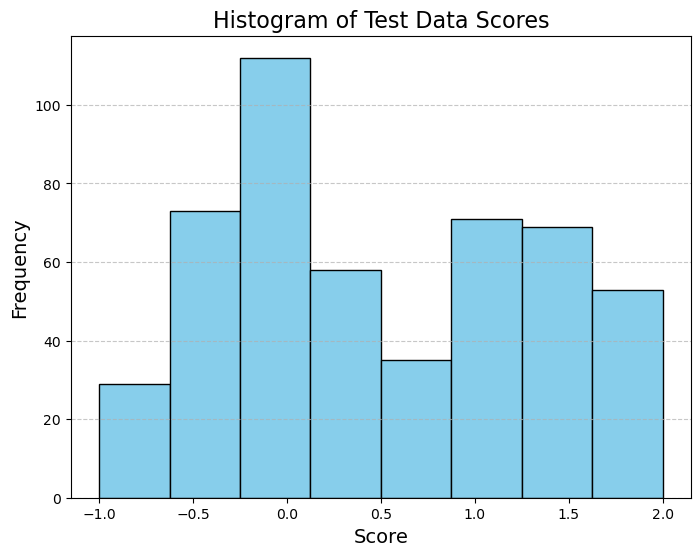

In [57]:
plt.figure(figsize=(8, 6))
plt.hist(scores, bins=int((prediction_scores.max() - prediction_scores.min()) / 0.25), edgecolor='black', color='skyblue')
plt.title("Histogram of Test Data Scores", fontsize=16)
plt.xlabel("Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [58]:
output_df = pd.DataFrame({
    "id": np.array(test_ids).flatten(),
    "score": prediction_scores.flatten()
})

output_df.to_csv("saves/submission28.csv", index=False)
model.save("saves/model28.h5")

# Evaluate

In [68]:
# Now, during the evaluation, you can reverse the standardization manually:
def evaluate_spearman(model, texts, true_scores):
    predictions = model.predict(texts).flatten()

    # Reverse scaling manually
    predictions = predictions 
    true_scores = true_scores
    
    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(predictions, true_scores)
    return spearman_corr

# Spearman correlation on validation set
val_spearman = evaluate_spearman(model, val_texts, val_scores)
print(f"Validation Spearman's rank correlation: {val_spearman}")

D:\Programs\Anaconda\envs\pymc_uni\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_51' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step
Validation Spearman's rank correlation: 0.5300654790010412


# Load a specific model from saved ones

In [59]:
loaded_model = load_model("saves/model28.h5", compile=False)
loaded_model.summary()

D:\Programs\Anaconda\envs\pymc_uni\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_31' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (32, 100)              │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_14 (Embedding)        │ (32, 100, 128)         │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (32, 100, 128)         │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (32, 100, 64)          │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (32, 100, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (32, 50, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (32, 50, 128)          │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (32, 50, 64)           │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (32, 50, 64)           │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (32, 25, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (32, 25, 256)          │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_11          │ (32, 25, 256)          │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (32, 128)              │       123,648 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_12          │ (32, 128)              │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (32, 128)              │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (32, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (32, 1)                │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,112,577 (11.87 MB)

 Trainable params: 3,112,321 (11.87 MB)

 Non-trainable params: 256 (1.00 KB)